In [1]:
#Import Base Python Data
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import os
import pyvista as pv
import plotly.graph_objects as go
import plotly.io as pio
import plotly

#Import Mesh Tools
from discretize import TensorMesh
from discretize.utils import mkvc

#Import SimPEG
from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG.potential_fields import gravity
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

In [2]:
%matplotlib inline

In [3]:
#Mendeskripsikan parameter model
xlen = 2000 #Ukuran box pada koordinat X (m)
ylen = 2000 #Ukuran box pada koordinat Y (m)
zlen = 1000 #Ukuran box pada koordinat Z (m)
ntopo = 61 #Jumlah titik topografi
nobs = 51 #Jumlah titik observasi
xmid = (nobs-1)/2 #untuk grafik anomali maksimum

xmin = -xlen/2
xmax = xlen/2
ymin = -ylen/2
ymax = ylen/2

[x_topo, y_topo] = np.meshgrid(np.linspace(xmin, xmax, ntopo), np.linspace(ymin, ymax, ntopo))
# z_topo = np.zeros(np.shape(x_topo))
z_topo = -15 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 80 ** 2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

In [4]:
# # Mendeskripsikan lokasi observasi sebagai matriks numpy (N,3) (bisa juga dengan load data)
# x = np.linspace(xmin, xmax, nobs)
# y = np.linspace(ymin, ymax, nobs)
# x, y = np.meshgrid(x, y)
# x, y = mkvc(x.T), mkvc(y.T)
# fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
# z = fun_interp(np.c_[x, y]) + 5
# receiver_locations = np.c_[x, y, z]
# Define the observation locations 
x = np.linspace(xmin, xmax, nobs)
y = np.linspace(ymin, ymax, nobs)
x, y = np.meshgrid(x, y)
nx = np.size(x)
ny = np.size(y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 5
nz = np.size(z)
receiver_locations = np.c_[x, y, z]

# Menentukan komponen bidang yang ingin disimulasikan sebagai bentuk string didalamnya
components = ["gxz", "gyz", "gzz","gz"]

# Menggunakan lokasi dan komponen observasi untuk menentukan receiver untuk
# menyimulasikan data. (Receiver harus ditentukan dalam bentuk list
receiver_list = gravity.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Menentukan sumber medan
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Mendefinisikan survey
survey = gravity.survey.Survey(source_field)

In [5]:
print(receiver_locations)

[[-1000. -1000.     5.]
 [ -960. -1000.     5.]
 [ -920. -1000.     5.]
 ...
 [  920.  1000.     5.]
 [  960.  1000.     5.]
 [ 1000.  1000.     5.]]


# **MEMBUAT MESH**

TensorMesh: 20,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40     -1,000.00      1,000.00     50.00     50.00    1.00
   y     25       -625.00        625.00     50.00     50.00    1.00
   z     20     -1,000.00          0.00     50.00     50.00    1.00

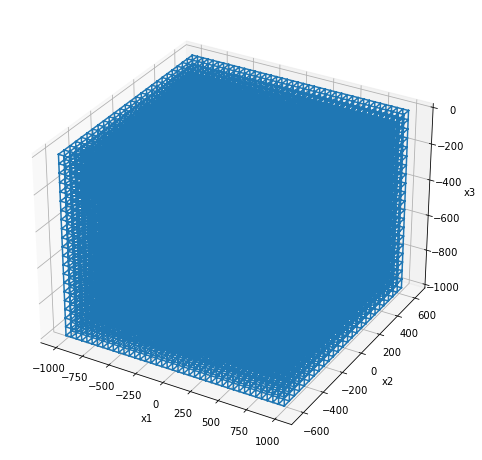

In [6]:
# Membuat Mesh dengan base Tensor
# dn = 600
# hx = [(dn, 5, -1.0), (dn, 20), (dn, 5, 1.0)]
# hy = [(dn, 5, -1.0), (dn, 25), (dn, 5, 1.0)]
# hz = [(100, 5, -1.2), (100, 50)]
# mesh = TensorMesh([hx, hy, hz], x0 = [420377.9273, 9194952.47, 'N'])
dh = 50.0
hx = [(dh, 5, -1.0), (dh, 30), (dh, 5, 1.0)]
hy = [(dh, 5, -1.0), (dh, 15), (dh, 5, 1.0)]
hz = [(dh, 5, -1.0), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

# fig = go.Figure(data = mesh)
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111, projection='3d')
mesh.plot_grid(ax=ax, edges=False, centers=False);
mesh
# fig.show()

In [7]:
# # MESH RAPS
# # dn = 600
# # hx = [(dn, 5, -1.0), (dn, 20), (dn, 5, 1.0)]
# # hy = [(dn, 5, -1.0), (dn, 25), (dn, 5, 1.0)]
# # hz = [(100, 5, -1.2), (100, 50)]
# # mesh = TensorMesh([hx, hy, hz], x0 = [420377.9273, 9194952.47, 'N'])
# dh = 300.0
# hx = [(dh, 5, -1.0), (dh, 30), (dh, 5, 1.0)]
# hy = [(dh, 5, -1.0), (dh, 15), (dh, 5, 1.0)]
# hz = [(dh, 5, -1.0), (dh, 15)]
# mesh = TensorMesh([hx, hy, hz], "CCN")

# # fig = go.Figure(data = mesh)
# fig = plt.figure(figsize=(8,12))
# ax = fig.add_subplot(111, projection='3d')
# mesh.plot_grid(ax=ax, edges=False, centers=False);
# mesh
# # fig.show()

In [8]:
# gridx = mesh.to_vtk()
# p = pv.Plotter()
# p.add_mesh(gridx)
# p.show()

In [9]:
# dn = 600
# hx = [(dn, 5, -1.0), (dn, 20), (dn, 5, 1.0)]
# hy = [(dn, 5, -1.0), (dn, 25), (dn, 5, 1.0)]
# hz = [(100, 5, -1.2), (100, 50)]
# mesh2 = TensorMesh([hx, hy, hz], x0 = [420377.9273, 9194952.47, 'N'])
# fig = plt.figure(figsize=(8,12))
# ax = fig.add_subplot(111, projection='3d')
# mesh2.plot_grid(ax=ax, edges=False, centers=False);
# mesh2

# **MENENTUKAN PARAMETER MODEL**

In [10]:
# Menentukan nilai kontras densitas pad atiap unit dalam satuan (g/cc)
background_density = 1e-4
block_density = 1
blockRAPS= 0.5
# sphere_density = 0.5

# Mencari indeks untuk sel mesh yang aktif (contoh: sel di bawah permukaan)
ind_active = surface2ind_topo(mesh, topo_xyz)

# Menentukan pemetaan dari model ke sel yang aktif.
# Model terdiri dari nilai untuk tiap sel aktif di bawah permukaan bumi
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

#Menentukan model. Model dalam SimPEG adalah sebuah vektor array
model = background_density * np.ones(nC)

# **MODEL BALOK VERTIKAL**

In [11]:
# # Membuat model objek blok dengan ukuran Panjang 400 m Lebar 100 m dan Tinggi 700 m
# # dengan kedalaman objek 200 m di bawah permukaan
# ind_block = model_builder.getIndicesBlock(np.r_[-200, -50, -900], np.r_[200, 50, -200], mesh.gridCC,
# )[0]
# model[ind_block] = block_density

# # Plot Model Kontras Densitas
# fig = plt.figure(figsize=(9, 6))
# plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

# ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
# mesh.plotSlice(
#     plotting_map * model,
#     normal="Y",
#     ax=ax1,
#     ind=int(mesh.nCy / 2),
#     grid=True,
#     clim=(np.min(model), np.max(model)),
#     pcolorOpts={"cmap": "viridis"},
# )
# # ax1.set_title("Potongan model pada sumbu y = 0 m")
# ax1.set_xlabel("x (m)")
# ax1.set_ylabel("z (m)", labelpad = 0)

# # ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
# divider = make_axes_locatable(ax1)
# cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
# ax2 = fig.add_axes(cax)
# norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
# cbar = mpl.colorbar.ColorbarBase(
#     ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.viridis
# )
# # norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
# # cbar = mpl.colorbar.ColorbarBase(
# #     ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
# cbar.set_label("$g/cm^3$", rotation=360, labelpad=0, size=12)

# plt.show()

## **MODEL VERTIKAL RAPS**

In [12]:
# # Membuat model objek blok dengan ukuran Panjang 400 m Lebar 100 m dan Tinggi 700 m
# # dengan kedalaman objek 200 m di bawah permukaan
# ind_block = model_builder.getIndicesBlock(np.r_[-1500, -500, -5000], np.r_[1500, 500, -2500], mesh.gridCC,
# )[0]
# model[ind_block] = blockRAPS

# # Plot Model Kontras Densitas
# fig = plt.figure(figsize=(9, 6))
# plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

# ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
# mesh.plotSlice(
#     plotting_map * model,
#     normal="Y",
#     ax=ax1,
#     ind=int(mesh.nCy / 2),
#     grid=True,
#     clim=(np.min(model), np.max(model)),
#     pcolorOpts={"cmap": "viridis"},
# )
# ax1.set_title("Potongan model pada sumbu y = 0 m")
# ax1.set_xlabel("x (m)")
# ax1.set_ylabel("z (m)", labelpad = 0)

# # ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
# divider = make_axes_locatable(ax1)
# cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
# ax2 = fig.add_axes(cax)
# norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
# cbar = mpl.colorbar.ColorbarBase(
#     ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.viridis
# )
# # norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
# # cbar = mpl.colorbar.ColorbarBase(
# #     ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
# cbar.set_label("$g/cm^3$", rotation=360, labelpad=0, size=12)

# plt.show()

## **MODEL HORIZONTAL RAPS**

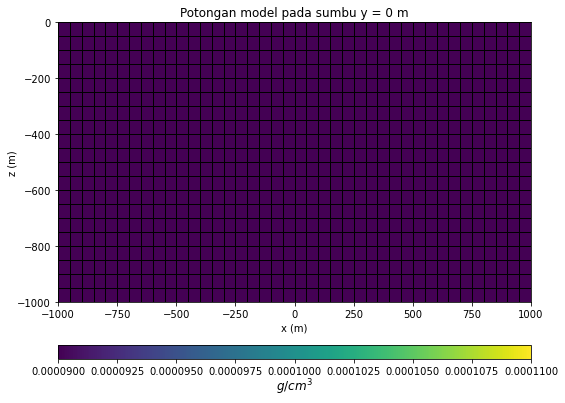

In [13]:
# Membuat model objek blok dengan ukuran Panjang 400 m Lebar 100 m dan Tinggi 700 m
# dengan kedalaman objek 200 m di bawah permukaan
ind_block = model_builder.getIndicesBlock(np.r_[-2000, -500, -4000], np.r_[2000, 500, -2000], mesh.gridCC,
)[0]
model[ind_block] = blockRAPS

# Plot Model Kontras Densitas
fig = plt.figure(figsize=(9, 6))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotSlice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Potongan model pada sumbu y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)", labelpad = 0)

# ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
ax2 = fig.add_axes(cax)
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.viridis
)
# norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
# cbar = mpl.colorbar.ColorbarBase(
#     ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
cbar.set_label("$g/cm^3$", rotation=360, labelpad=0, size=12)

plt.show()

# **MODEL BALOK HORIZONTAL**

In [14]:
# # Membuat model objek blok dengan ukuran Panjang 400 m Lebar 100 m dan Tinggi 700 m
# # dengan kedalaman objek 200 m di bawah permukaan
# ind_block = model_builder.getIndicesBlock(np.r_[-500, -50, -500], np.r_[500, 50, -200], mesh.gridCC,
# )[0]
# model[ind_block] = block_density

# # Plot Model Kontras Densitas
# fig = plt.figure(figsize=(9, 6))
# plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

# ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
# mesh.plotSlice(
#     plotting_map * model,
#     normal="Y",
#     ax=ax1,
#     ind=int(mesh.nCy / 2),
#     grid=True,
#     clim=(np.min(model), np.max(model)),
#     pcolorOpts={"cmap": "viridis"},
# )
# ax1.set_title("Potongan model pada sumbu y = 0 m")
# ax1.set_xlabel("x (m)")
# ax1.set_ylabel("z (m)", labelpad = -2)

# # ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
# divider = make_axes_locatable(ax1)
# cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
# ax2 = fig.add_axes(cax)
# norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
# cbar = mpl.colorbar.ColorbarBase(
#     ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.viridis
# )
# cbar.set_label("$g/cm^3$", rotation=360, labelpad=0, size=12)

# plt.show()

# **MODEL PATAHAN**

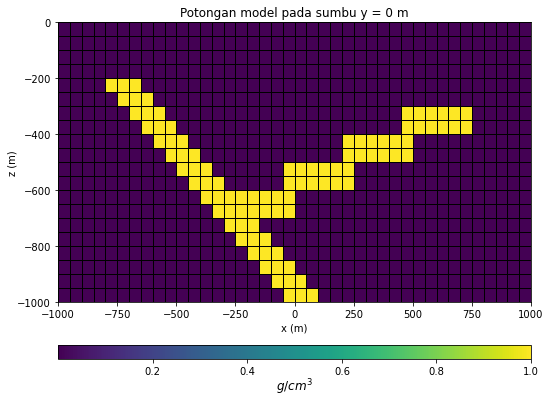

In [15]:
# Membuat model patahan
ind_block1 = model_builder.getIndicesBlock(np.r_[-800, -50, -250], np.r_[-650, 50, -200], mesh.gridCC)[0]
ind_block2 = model_builder.getIndicesBlock(np.r_[-750, -50, -300], np.r_[-600, 50, -250], mesh.gridCC)[0]
ind_block3 = model_builder.getIndicesBlock(np.r_[-700, -50, -350], np.r_[-550, 50, -300], mesh.gridCC)[0]
ind_block4 = model_builder.getIndicesBlock(np.r_[-650, -50, -400], np.r_[-500, 50, -350], mesh.gridCC)[0]
ind_block5 = model_builder.getIndicesBlock(np.r_[-600, -50, -450], np.r_[-450, 50, -400], mesh.gridCC)[0]
ind_block6 = model_builder.getIndicesBlock(np.r_[-550, -50, -500], np.r_[-400, 50, -450], mesh.gridCC)[0]
ind_block7 = model_builder.getIndicesBlock(np.r_[-500, -50, -550], np.r_[-350, 50, -500], mesh.gridCC)[0]
ind_block8 = model_builder.getIndicesBlock(np.r_[-450, -50, -600], np.r_[-300, 50, -550], mesh.gridCC)[0]
ind_block9 = model_builder.getIndicesBlock(np.r_[-400, -50, -650], np.r_[-250, 50, -600], mesh.gridCC)[0]
ind_block10 = model_builder.getIndicesBlock(np.r_[-350, -50, -700], np.r_[-200, 50, -650], mesh.gridCC)[0]
ind_block11 = model_builder.getIndicesBlock(np.r_[-300, -50, -750], np.r_[-150, 50, -700], mesh.gridCC)[0]
ind_block12 = model_builder.getIndicesBlock(np.r_[-250, -50, -800], np.r_[-100, 50, -750], mesh.gridCC)[0]
ind_block13 = model_builder.getIndicesBlock(np.r_[-200, -50, -850], np.r_[-50, 50, -800], mesh.gridCC)[0]
ind_block14 = model_builder.getIndicesBlock(np.r_[-150, -50, -900], np.r_[0, 50, -850], mesh.gridCC)[0]
ind_block15 = model_builder.getIndicesBlock(np.r_[-100, -50, -950], np.r_[50, 50, -900], mesh.gridCC)[0]
ind_block16 = model_builder.getIndicesBlock(np.r_[-50, -50, -1000], np.r_[100, 50, -950], mesh.gridCC)[0]
ind_block17 = model_builder.getIndicesBlock(np.r_[0, -50, -1050], np.r_[150, 50, -1000], mesh.gridCC)[0]
ind_block18 = model_builder.getIndicesBlock(np.r_[-300, -50, -600], np.r_[0, 50, -700], mesh.gridCC)[0]
ind_block19 = model_builder.getIndicesBlock(np.r_[-50, -50, -500], np.r_[250, 50, -600], mesh.gridCC)[0]
ind_block20 = model_builder.getIndicesBlock(np.r_[200, -50, -400], np.r_[500, 50, -500], mesh.gridCC)[0]
ind_block21 = model_builder.getIndicesBlock(np.r_[450, -50, -300], np.r_[750, 50, -400], mesh.gridCC)[0]


model[ind_block1] = block_density
model[ind_block2] = block_density
model[ind_block3] = block_density
model[ind_block4] = block_density
model[ind_block5] = block_density
model[ind_block6] = block_density
model[ind_block7] = block_density
model[ind_block8] = block_density
model[ind_block9] = block_density
model[ind_block10] = block_density
model[ind_block11] = block_density
model[ind_block12] = block_density
model[ind_block13] = block_density
model[ind_block14] = block_density
model[ind_block15] = block_density
model[ind_block16] = block_density
model[ind_block17] = block_density
model[ind_block18] = block_density
model[ind_block19] = block_density
model[ind_block20] = block_density
model[ind_block21] = block_density

# Plot Model Kontras Densitas
fig = plt.figure(figsize=(9, 6))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotSlice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Potongan model pada sumbu y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)", labelpad = 0)

# ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
ax2 = fig.add_axes(cax)
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=360, labelpad=0, size=12)

plt.show()

In [16]:
print(model)
print(mesh.gridCC)
print(np.min(model))
print(np.max(model))
plotly.__version__

[0.0001 0.0001 0.0001 ... 0.0001 0.0001 0.0001]
[[-975. -600. -975.]
 [-925. -600. -975.]
 [-875. -600. -975.]
 ...
 [ 875.  600.  -25.]
 [ 925.  600.  -25.]
 [ 975.  600.  -25.]]
0.0001
1.0


'5.11.0'

In [17]:
# #3D Model View
# fig= go.Figure(data=go.Isosurface(
#     x= mesh.gridCC[:,0],
#     y= mesh.gridCC[:,1],
#     z= mesh.gridCC[:,2],
#     value=model,
#     isomin=0.01,
#     isomax=1.01,
#     opacity=1,
#     colorscale='Viridis',
#     colorbar_orientation='v',
#     colorbar=dict(bgcolor='white',thickness=0,thicknessmode='pixels'),
#     showscale=False
# ))
# # # fig.update_traces(
# # #     colorbar=False,
# # #     colorbar_orientation='h',
# # #     colorbar_y=0
# # )
# fig.show()
# # pio.write_image(fig, 'filename.pdf', width=1920, height=1080)
# plotly.offline.plot(fig, filename='test_patahan.html')

# **FORWARD SIMULATION**

In [18]:
import time
t = time.time()
# Mendefinisikan Forward Simulation
# NOTE: Menentukan keyword "store_sensitivities" argumen ke "forward only"
#       untuk menyimulasikan data tanpa menyimpan sensitivitasnya.
simulation = gravity.simulation.Simulation3DIntegral(
    survey = survey,
    mesh   = mesh,
    rhoMap = model_map,
    actInd = ind_active,
    store_sensitivities = "forward_only",
) 
# Memulai Forward Simulation
# SimPEG menggunakan koordinat tangan kanan dimana Z positif menuju ke atas
# Hal ini membuat sinyal gravitasi terlihat "inkonsisten" pada densitas di visualisasi
dpred = simulation.dpred(model)
n_data = len(dpred)
print("FORWARD SIMULATION SELESAI! Waktu yang dibutuhkan = {:1.2f} s".format(time.time() - t))

FORWARD SIMULATION SELESAI! Waktu yang dibutuhkan = 83.81 s


# **PLOT ANOMALI GRAVITASI**

In [19]:
print(np.shape(dpred))
print(np.max(dpred))
print(np.abs(dpred[3:n_data:4]))
print(np.shape(receiver_locations))

(10404,)
25.102186575693125
[0.04086714 0.04267634 0.0445078  ... 0.03956337 0.03784768 0.0361686 ]
(2601, 3)


In [20]:
# # Plot
# fig = plt.figure(figsize=(18, 12))
# n_locations = receiver_locations.shape[0]
# v_max = np.max(np.abs(dpred))

# ax1 = fig.add_axes([0.62, 0.15, 0.25, 0.78])
# cplot1 = plot2Ddata(
#     receiver_locations,
#     dpred[0:n_data:1],
#     ax=ax1,
#     ncontour=30,
#     clim=(-v_max, v_max),
#     contourOpts={"cmap": "jet"}
# )
# cplot1[0].set_clim((-v_max, v_max))
# # ax1.set_title("$\partial g /\partial z$")
# ax1.set_title("Anomali Gravitasi")
# ax1.set_xlabel("x (m)")
# ax1.set_ylabel("y (m)")
# # ax1.set_yticks([])

# ax2 = fig.add_axes([0.89, 0.352, 0.015, 0.38])
# norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
# cbar = mpl.colorbar.ColorbarBase(
#     ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet, 
# )
# cbar.set_label("$mGal$", rotation=270, labelpad=16, size=12)

# plt.show()

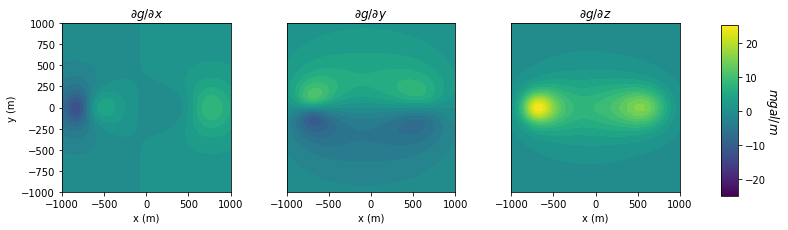

In [21]:
# Plot
fig = plt.figure(figsize=(12, 3))
n_locations = receiver_locations.shape[0]
v_max = np.max(np.abs(dpred))

#dg/dx
ax1 = fig.add_axes([0.1, 0.15, 0.25, 0.78])
cplot1 = plot2Ddata(
    receiver_locations,
    dpred[0:n_data:4],
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "viridis"},
)
cplot1[0].set_clim((-v_max, v_max))
ax1.set_title("$\partial g /\partial x$")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

#dg/dy
ax2 = fig.add_axes([0.36, 0.15, 0.25, 0.78])
cplot2 = plot2Ddata(
    receiver_locations,
    dpred[1:n_data:4],
    ax=ax2,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "viridis"},
)
cplot2[0].set_clim((-v_max, v_max))
ax2.set_title("$\partial g /\partial y$")
ax2.set_xlabel("x (m)")
ax2.set_yticks([])

#VGG
ax3 = fig.add_axes([0.62, 0.15, 0.25, 0.78])
cplot3 = plot2Ddata(
    receiver_locations,
    dpred[2:n_data:4],
    ax=ax3,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "viridis"},
)
cplot3[0].set_clim((-v_max, v_max))
ax3.set_title("$\partial g /\partial z$")
ax3.set_xlabel("x (m)")
ax3.set_yticks([])

ax4 = fig.add_axes([0.89, 0.13, 0.02, 0.79])
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar = mpl.colorbar.ColorbarBase(
    ax4, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$mgal/m$", rotation=270, labelpad=15, size=12)

plt.show()

In [22]:
print(np.abs(dpred[3:n_data:4]))
g_max = np.max(np.abs(dpred[3:n_data:4]))
g_min = np.min(np.abs(dpred[3:n_data:4]))
n_locations = receiver_locations.shape[0]

dpred2 = dpred*5

[0.04086714 0.04267634 0.0445078  ... 0.03956337 0.03784768 0.0361686 ]


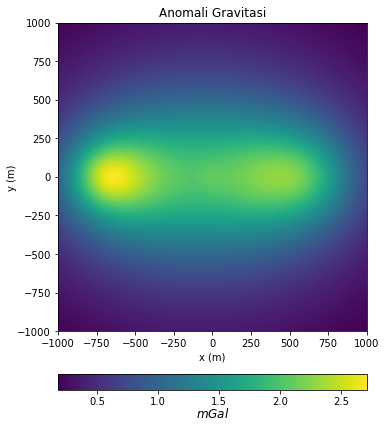

In [23]:
# plot gravity anomaly
fig = plt.figure(figsize=(9, 6))
n_locations = receiver_locations.shape[0]
g_max = np.max(np.abs(dpred2[3:n_data:4]))
g_min = np.min(np.abs(dpred2[3:n_data:4]))

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
cplot1 = plot2Ddata(
    receiver_locations,
    (np.abs(dpred2[3:n_data:4])),
    ax=ax1,
    ncontour=100,
    clim=(g_min, g_max),
    contourOpts={"cmap": "viridis"},
)
cplot1[0].set_clim((g_min, g_max))
ax1.set_title("Anomali Gravitasi")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)", labelpad = 0)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
ax2 = fig.add_axes(cax)
norm = mpl.colors.Normalize(vmin=g_min, vmax=g_max)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.viridis
)
cbar.set_label("$mGal$", rotation=360, labelpad=0, size=12)

plt.show()

# **FIRST HORIZONTAL DERIVATIVE**

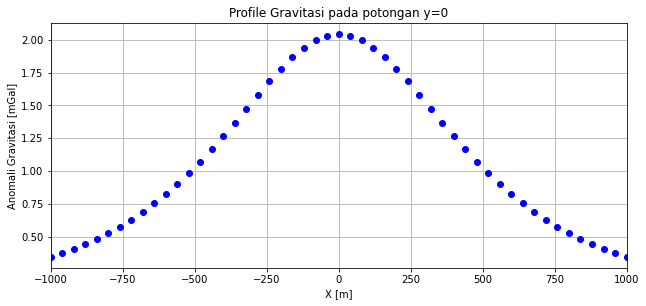

In [112]:
#reshape dpred

# dpred2 = dpred
dpred3 = np.reshape((np.abs(dpred2)), (nobs, nobs, 4))
receiver_locations2 = np.reshape(receiver_locations, (nobs, nobs, 3))

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.15, 0.1, 0.8, 0.85])
ax1.plot(receiver_locations2[:, 20, 1],dpred3[:, 20, 3],"ob")
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Anomali Gravitasi [mGal]")
ax1.set_title("Profile Gravitasi pada potongan y=0")
# ax1.invert_yaxis()

plt.xlim(-1000,1000)
plt.grid()
plt.show()

In [113]:
# MM = np.array(receiver_locations[:,0])
# print(len(MM))
dpredx = (np.abs(dpred[3:n_data:4]))*5
dpredy = (np.abs(dpred[3:n_data:4]))

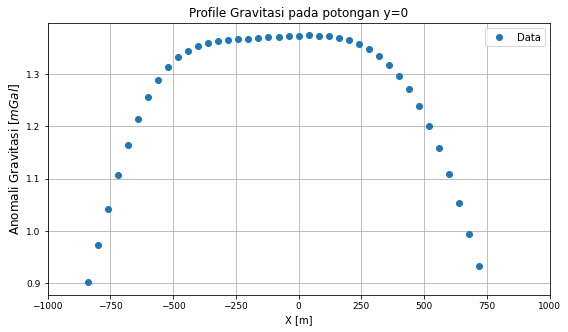

In [114]:
#First Horizontal Derivative
MM = np.array(receiver_locations[:,0])

fig, ax = plt.subplots(figsize = (9,5))
ax.plot(MM[820:860], dpredx[820:860], 'o', label='Data')
ax.tick_params(axis='both', labelsize=9)
ax.set_title("Profile Gravitasi pada potongan y=0")
ax.set_xlabel("X [m]")
ax.set_ylabel('Anomali Gravitasi [$mGal$]', fontdict={'fontsize': 12})
ax.legend(fontsize='medium', bbox_to_anchor=(0.99, 0.98), loc='upper right', borderaxespad=0)
# ax.invert_yaxis()

plt.xlim(-1000,1000)
plt.grid()
plt.show()

In [115]:
# save_output = True
# if save_output:

#     dir_path = os.path.dirname('./Downloads/Gravity/Synthetic Data/output').split(os.path.sep)
#     dir_path.extend(["outputs"])
#     dir_path = os.path.sep.join(dir_path) + os.path.sep

#     if not os.path.exists(dir_path):
#         os.mkdir(dir_path)

#     fname = dir_path + "gravity_topo_RAPS2.txt"
#     np.savetxt(fname, np.c_[topo_xyz], fmt="%.4e")

#     np.random.seed(737)
#     maximum_anomaly = np.max(np.abs(dpred))
#     noise = 0.01 * maximum_anomaly * np.random.rand(len(dpred))
#     fname = dir_path + "gravity_data_RAPS2.obs"
#     np.savetxt(fname, np.c_[receiver_locations,
#                             dpredy],
#                             fmt="%.4e")
    
# save_output

In [116]:
from mpl_toolkits.mplot3d import Axes3D

In [117]:
dpred3
receiver_locations2

array([[[-1000., -1000.,     5.],
        [ -960., -1000.,     5.],
        [ -920., -1000.,     5.],
        ...,
        [  920., -1000.,     5.],
        [  960., -1000.,     5.],
        [ 1000., -1000.,     5.]],

       [[-1000.,  -960.,     5.],
        [ -960.,  -960.,     5.],
        [ -920.,  -960.,     5.],
        ...,
        [  920.,  -960.,     5.],
        [  960.,  -960.,     5.],
        [ 1000.,  -960.,     5.]],

       [[-1000.,  -920.,     5.],
        [ -960.,  -920.,     5.],
        [ -920.,  -920.,     5.],
        ...,
        [  920.,  -920.,     5.],
        [  960.,  -920.,     5.],
        [ 1000.,  -920.,     5.]],

       ...,

       [[-1000.,   920.,     5.],
        [ -960.,   920.,     5.],
        [ -920.,   920.,     5.],
        ...,
        [  920.,   920.,     5.],
        [  960.,   920.,     5.],
        [ 1000.,   920.,     5.]],

       [[-1000.,   960.,     5.],
        [ -960.,   960.,     5.],
        [ -920.,   960.,     5.],
        .

# **MENYIAPKAN DATA UNTUK INVERSI**

In [118]:
#Menambahkan noise pada data

maximum_anomaly = np.max(np.abs(dpred))

uncertainties = 0.03 * maximum_anomaly * np.ones(np.shape(dpred))

In [119]:
#Menjadikan data sintetik (observasi) menjadi Inversion Data Object

data_object = data.Data(survey, dobs=dpred, standard_deviation=uncertainties)

simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey, mesh=mesh, rhoMap=model_map, actInd=ind_active
)

# **SPARSE INVERSION**

In [120]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)
dmis.W = utils.sdiag(1 / uncertainties)

# Define the regularization (model objective function).
reg = regularization.Sparse(mesh, indActive=ind_active, mapping=model_map)
reg.norms = np.c_[0, 2, 2, 2]

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=0.05)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.Update_IRLS(
    f_min_change=1e-4,
    max_irls_iterations=20,
    coolEpsFact=1.5,
    beta_tol=1e-2,
)

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

save_directive = directives.SaveModelEveryIteration()

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)

# The directives are defined as a list.
directives_list = [
    update_IRLS,
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    save_directive,
    update_jacobi,
]

# **LEAST SQUARE INVERSION**

In [121]:
# # Define the data misfit. Here the data misfit is the L2 norm of the weighted
# # residual between the observed data and the data predicted for a given model.
# # Within the data misfit, the residual between predicted and observed data are
# # normalized by the data's standard deviation.
# dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# # Define the regularization (model objective function).
# reg = regularization.Simple(mesh, indActive=ind_active, mapping=model_map)

# # Define how the optimization problem is solved. Here we will use a projected
# # Gauss-Newton approach that employs the conjugate gradient solver.
# opt = optimization.ProjectedGNCG(
#     maxIter=10, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
# )

# # Here we define the inverse problem that is to be solved
# inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# # Defining a starting value for the trade-off parameter (beta) between the data
# # misfit and the regularization.
# starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# # Defining the fractional decrease in beta and the number of Gauss-Newton solves
# # for each beta value.
# beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# # Options for outputting recovered models and predicted data for each beta.
# save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
# save_directive = directives.SaveModelEveryIteration()

# # Updating the preconditionner if it is model dependent.
# update_jacobi = directives.UpdatePreconditioner()

# # Setting a stopping criteria for the inversion.
# target_misfit = directives.TargetMisfit(chifact=1)

# # Add sensitivity weights
# sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)

# # The directives are defined as a list.
# directives_list = [
#     sensitivity_weights,
#     starting_beta,
#     beta_schedule,
#     save_iteration,
#     save_directive,
#     update_jacobi,
#     target_misfit,
# ]

# **MEMULAI INVERSI**

In [122]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
starting_model = background_density * np.ones(nC)
recovered_model = inv.run(starting_model)
print("INVERSI SELESAI! Waktu yang dibutuhkan = {:1.2f} s".format(time.time() - t))

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveModelEveryIteration will save your models as: './###-InversionModel-2023-03-27-21-36.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.42e-01  1.05e+05  0.00e+00  1.05e+05    1.41e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.12806272031042676 eps_q: 0.12806272031042676
   1  1.42e-02  1.51e+01  6.36e+03  1.05e+02    1.02e+02      0              
   2  1.26e+00  5.87e+00  8.12e+03  1.03e+04    1.42e+02      0   Skip BFGS  
   3  1.00e+00  8.76e+02  8.28e+03  9.18e+03    1.37e+02      0

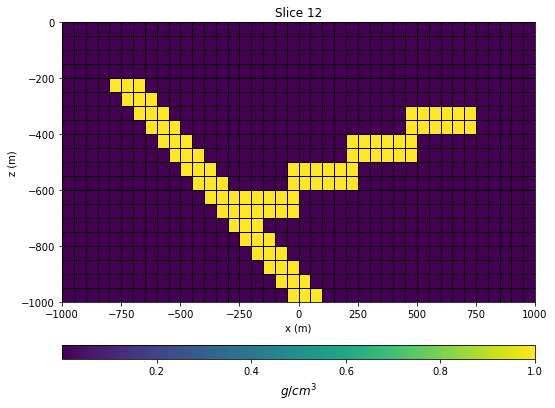

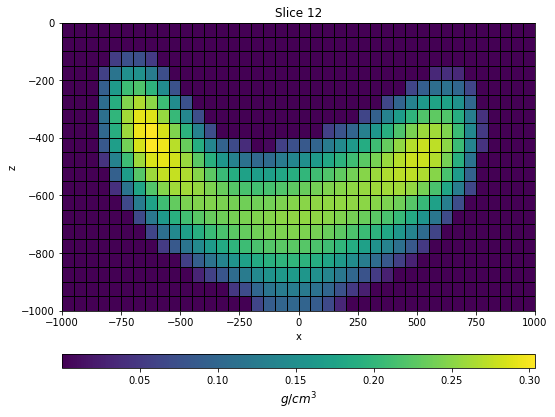

In [123]:
# Plot Model Kontras Densitas
fig = plt.figure(figsize=(9, 6))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotSlice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolorOpts={"cmap": "viridis"},
)
# ax1.set_title("Potongan model pada sumbu y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

# ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
ax2 = fig.add_axes(cax)
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=360, labelpad=5, size=12)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(9, 6))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plotSlice(
    plotting_map * recovered_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolorOpts={"cmap": "viridis"},
)
# ax1.set_title("Potongan model pada sumbu y = 0 m")

# ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
ax2 = fig.add_axes(cax)
norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=360, labelpad=5, size=12)

plt.show()

In [124]:
b = plotting_map * model
c = plotting_map * recovered_model
dtrue = inv_prob.dpred

In [125]:
#Profile data
print(len(recovered_model))
print(len(model))
print(len(dpred))
print(len(dtrue))
print(np.max(dpred))
print(np.max(dtrue))

20000
20000
10404
10404
25.102186575693125
23.111747970420392


In [126]:
p = pv.Plotter()
p.add_mesh(c)

NotImplementedError: NumPy array could not be wrapped pyvista.

## **Korelasi PEARSON**

In [127]:
# Pearson Coeficient
print(len(b))
print(len(c))
corr = np.corrcoef(b,c)
print(corr)

20000
20000
[[1.         0.48420755]
 [0.48420755 1.        ]]


## **RMSe**

In [128]:
import math
# o = (dpred - dtrue) / uncertainties
# p = sum(o)/
dp = (dpred - dtrue)**2
dpx = sum(dp)/len(dpred)
print("\nLp model final misfit:" + str(np.sum(((dpred-dtrue)/uncertainties)**2.)))
print("Lp misfit sum(obs-calc)/nobs: %.3f mGal"  %np.divide(np.sum(np.abs(dpred-dtrue)), len(dpred)))
print("Lp RMS misfit: %.3f mGal" %np.sqrt(np.divide(np.sum((dpred-dtrue)**2),len(dpred))))
# print("Pearson misfit: %.3f" %np.divide((len(dpred))*(np.sum(np.abs(dpred*dtrue))))-np.abs(np.sum(dpred)*(np.abs(np.sum(dtrue))), (np.sqrt(((len(dpred))*(np.sum(dpred**2))))-(np.sum(dpred)**2)))*(len(dpred))*(np.sum(dtrue**2)-(np.sum(dtrue)**2))))


Lp model final misfit:1283.6377101125017
Lp misfit sum(obs-calc)/nobs: 0.152 mGal
Lp RMS misfit: 0.265 mGal


## **Grafik fitting data sintetik dan hasil inversi**

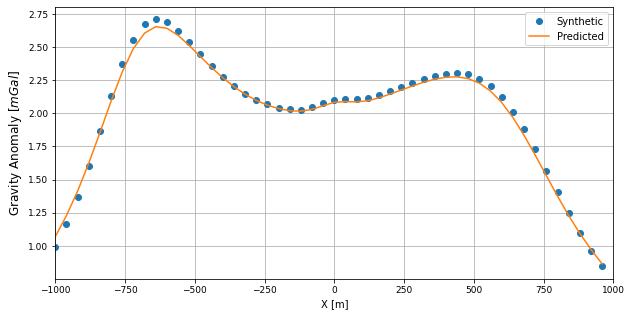

In [129]:
#First Horizontal Derivative
MM = np.array(receiver_locations[:,0])
dtruex = (np.abs(dtrue[3:n_data:4]))*5

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(MM[1275:1325], dpredx[1275:1325], 'o', label='Synthetic')
ax.plot(MM[1275:1325], dtruex[1275:1325], '-', label='Predicted')
ax.tick_params(axis='both', labelsize=9)
# ax.set_title("Gravity Anomaly (mGal)")
ax.set_xlabel("X [m]")
ax.set_ylabel('Gravity Anomaly [$mGal$]', fontdict={'fontsize': 12})
ax.legend(fontsize='medium', bbox_to_anchor=(0.99, 0.98), loc='upper right', borderaxespad=0)
# ax.invert_yaxis()

plt.xlim(-1000,1000)
plt.grid()
plt.show()

In [96]:
print(len(MM))
print(len(dpredx))
print(len(dtruex))
print(len(receiver_locations))

2601
2601
2601
2601


ValueError: Dimension mismatch in InjectActiveCells(20000,20000) and np.ndarray(50000,).

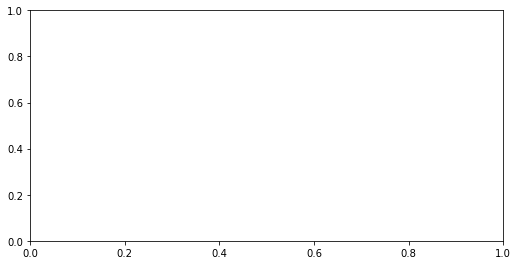

In [27]:
dir_list = (os.listdir('./Downloads/Gravity/Balok Horizontal/Inversion/Least Square'))
x = np.load('./Downloads/Gravity/Balok Horizontal/Inversion/Least Square/003-InversionModel-2022-06-27-20-47.npy')
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plotSlice(
    plotting_map * x,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(x), np.max(x)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Anomali Gravitasi pada y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(x), vmax=np.max(x))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=20, size=12)

plt.show()
# print(dir_list)

ValueError: Dimension mismatch in InjectActiveCells(20000,20000) and np.ndarray(50000,).

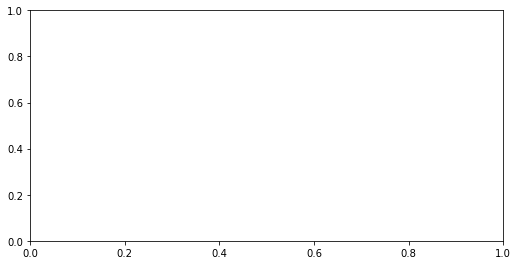

In [28]:
from glob import glob

npydata = sorted(glob('./Downloads/Gravity/Balok Horizontal/Inversion/Least Square/*.npy'))
for x in npydata:
    with open(x,"r") as fin:
        x = np.load(x)
        fig = plt.figure(figsize=(9, 4))
        plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

        ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
        mesh.plotSlice(
            plotting_map * x,
            normal="Y",
            ax=ax1,
            ind=int(mesh.nCy / 2),
            grid=True,
            clim=(np.min(x), np.max(x)),
            pcolorOpts={"cmap": "viridis"},
        )
        ax1.set_title("Anomali Gravitasi pada y = 0 m")

        ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
        norm = mpl.colors.Normalize(vmin=np.min(x), vmax=np.max(x))
        cbar = mpl.colorbar.ColorbarBase(
            ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
        )
        cbar.set_label("$g/cm^3$", rotation=270, labelpad=20, size=12)

        plt.show()

In [31]:
# if save_output:

#     dir_path = os.path.dirname(__file__).split(os.path.sep)
#     dir_path.extend(["outputs"])
#     dir_path = os.path.sep.join(dir_path) + os.path.sep

#     if not os.path.exists(dir_path):
#         os.mkdir(dir_path)

#     fname = dir_path + "gravity_topo.txt"
#     np.savetxt(fname, np.c_[topo_xyz], fmt="%.4e")

#     np.random.seed(737)
#     maximum_anomaly = np.max(np.abs(dpred))
#     noise = 0.01 * maximum_anomaly * np.random.rand(len(dpred))
#     fname = dir_path + "gravity_data.obs"
#     np.savetxt(fname, np.c_[receiver_locations, dpred + noise], fmt="%.4e")